# Time Series ItalyPowerDemand 

## 1. Business Understanding
Project ini memfokuskan kajian pada pemetaan pola penggunaan energi listrik dengan metode klasifikasi time series. Setiap periode pemakaian listrik dapat menunjukkan kecenderungan yang berbeda, sehingga diperlukan analisis untuk memahami pola yang muncul dari data tersebut. Pada kali ini, analisis time series tidak hanya digunakan untuk prediksi, melainkan juga untuk mengidentifikasi bentuk pola dan mengelompokkannya ke dalam kategori tertentu.

Masalah utama yang ingin diselesaikan yaitu bagaimana menentukan kelas suatu rangkaian konsumsi listrik di Italia berdasarkan bentuk perubahan nilainya sepanjang waktu. Tugas klasifikasi pada dataset ItalyPowerDemand bertujuan untuk membedakan pola konsumsi listrik harian antara periode Oktober–Maret (Musim Gugur & Musim Dingin) dan periode April–September (Musim Semi & Musim panas) berdasarkan bentuk time-series 24 jam dari setiap hari.

Melalui proses klasifikasi, penelitian ini diharapkan mampu memberikan ilustrasi mengenai variasi pola penggunaan energi yang muncul, sehingga dapat menjadi landasan dalam analisis lebih lanjut. Seluruh proses disusun mengikuti tahapan CRISP-DM yang meliputi pemahaman masalah, persiapan data, pembangunan model, hingga evaluasi hasil.


# 2. Data Understanding
Dataset Italy Power Demand merupakan kumpulan data time series yang bersumber dari UCR/UEA Repository dan banyak digunakan dalam penelitian klasifikasi deret waktu. Setiap baris merepresentasikan satu contoh sinyal konsumsi daya listrik harian dengan label kelas pada kolom pertama, sedangkan 24 nilai berikutnya menggambarkan urutan pengamatan pada setiap titik waktu.

Dataset telah disediakan dalam dua bagian, yaitu data latih dan data uji, masing-masing berjumlah 67 dan 1029 sampel. Pembagian ini merupakan konfigurasi bawaan penyedia dataset sehingga eksperimen dilakukan dengan mengikuti struktur tersebut.

Berdasarkan pemeriksaan awal, tidak ditemukan missing value maupun data non-numeric, sehingga dataset dapat langsung diolah tanpa proses imputasi tambahan. Pemeriksaan terhadap nilai ekstrem menunjukkan terdapat sekitar 327 nilai yang teridentifikasi sebagai outlier, namun karena data ini berasal dari sumber benchmark dan fluktuasi tersebut merupakan bagian dari karakteristik sinyal daya listrik, nilai tersebut tetap dipertahankan.

Selain itu, karena dataset bersifat univariate dan telah berlabel, analisis fokus pada proses klasifikasi pola berdasarkan bentuk sinyal time series, bukan pembuatan label baru. Tidak adanya informasi tanggal atau periode eksplisit membuat pendekatan diarahkan pada pola nilai terhadap urutan titik waktu, bukan pada aspek kalender secara langsung.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sktime.transformations.panel.rocket import MiniRocket
from sklearn.preprocessing import StandardScaler
import streamlit as st


Type Dataset: JumlahData JumlahFitur
Detail dataset TRAIN: (67, 25)
Detail dataset TEST: (1029, 25)


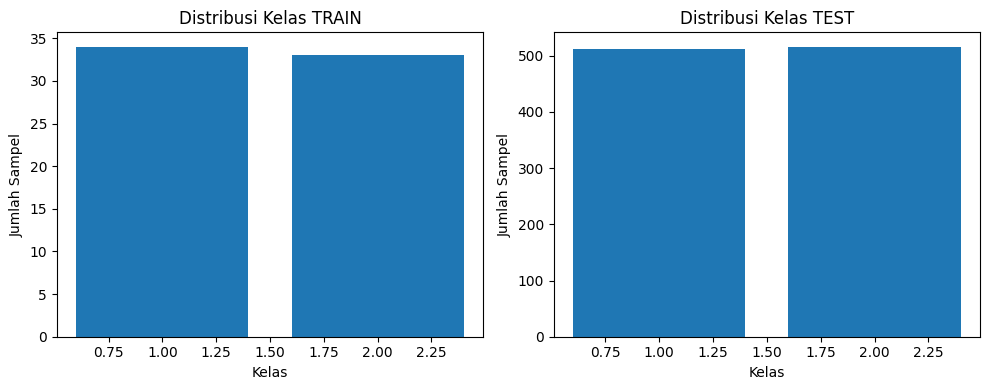

In [37]:
train = pd.read_csv("ItalyPowerDemand_TRAIN.txt", sep=r"\s+", header=None)
test  = pd.read_csv("ItalyPowerDemand_TEST.txt",  sep=r"\s+", header=None)

print("\nType Dataset:", "JumlahData", "JumlahFitur")
print("Detail dataset TRAIN:", train.shape)
print("Detail dataset TEST:", test.shape)
train_counts = Counter(train.iloc[:,0].astype(int))
test_counts  = Counter(test.iloc[:,0].astype(int))

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Distribusi Kelas TRAIN")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Sampel")

plt.subplot(1,2,2)
plt.bar(test_counts.keys(), test_counts.values())
plt.title("Distribusi Kelas TEST")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Sampel")

plt.tight_layout()
plt.show()


In [17]:
df = pd.concat([train, test], ignore_index=True)
print("Total Missing Values:", df.isna().sum().sum())
print("\nMissing by Column:")
print(df.isna().sum())


Total Missing Values: 0

Missing by Column:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
dtype: int64


In [18]:
non_numeric = df.applymap(lambda x: isinstance(x, str)).any()
print("Ada non-numeric?", non_numeric.any())

Ada non-numeric? False


C:\Users\Syafiq Azizi\AppData\Local\Temp\ipykernel_23496\1842258427.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric = df.applymap(lambda x: isinstance(x, str)).any()


In [19]:
values = df.iloc[:,1:]

mean = values.mean()
std  = values.std()

z = (values - mean) / std

outliers = (np.abs(z) > 3)

print("Jumlah Outlier:", outliers.sum().sum())



Jumlah Outlier: 327


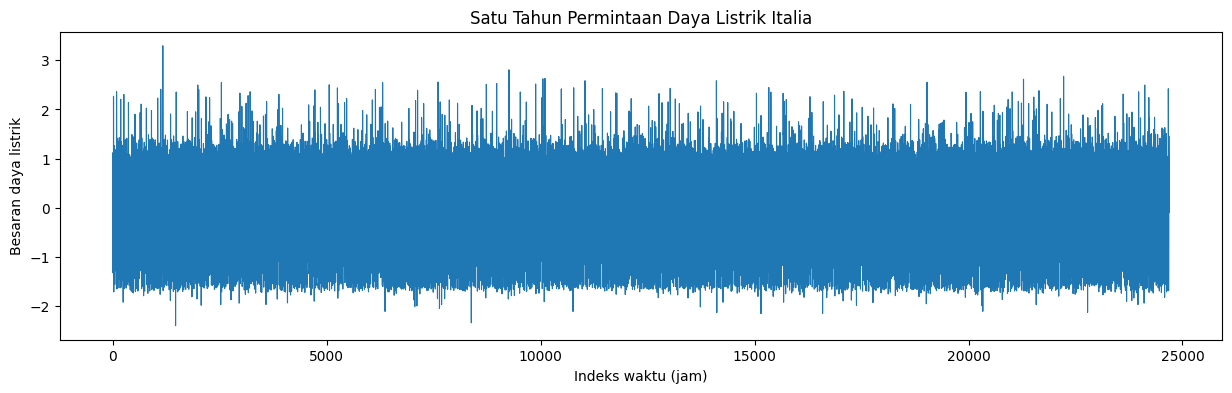

In [20]:
X = test.iloc[:,1:].values
full_series = X.flatten()

plt.figure(figsize=(15,4))
plt.plot(full_series, linewidth=0.8)

plt.title("Satu Tahun Permintaan Daya Listrik Italia")
plt.xlabel("Indeks waktu (jam)")
plt.ylabel("Besaran daya listrik")
plt.show()

# 3. Data Preparation

Walaupun dalam dataset terlihat ada beberapa nilai yang cukup ekstrem, nilai-nilai tersebut sebenarnya merupakan bagian dari pola data penggunaan listrik sehari-hari, bukan kesalahan data. Karena data ini berasal dari sumber resmi dan sudah dikurasi, nilai ekstrem tersebut justru bisa menggambarkan kondisi tertentu, misalnya perubahan penggunaan listrik pada jam tertentu atau pengaruh musim. Kalau nilai itu diubah atau dihapus, justru bisa menghilangkan informasi penting untuk proses klasifikasi. Karena alasan tersebut, outlier tetap dipertahankan dan tidak diproses lebih lanjut pada tahap preprocessing.

Pada dataset ini tidak dilakukan proses pemisahan data karena pembagian antara data latih dan data uji sudah ditentukan pada dataset asli, sehingga eksperimen mengikuti struktur yang telah disediakan oleh sumber data.

# 4. Modeling

Pada tahap modelling, dilakukan pembangunan model klasifikasi untuk mengidentifikasi pola konsumsi daya listrik pada dataset ItalyPowerDemand. Proses ini bertujuan untuk menghasilkan model yang memiliki performa klasifikasi yang baik serta dapat diintegrasikan ke dalam sistem prediksi berbasis Streamlit.

Sebagai langkah awal, digunakan model Random Forest sebagai baseline. Model ini dipilih karena kemampuannya dalam menangani data berdimensi tinggi serta stabil terhadap variasi data. Pelatihan model baseline dilakukan menggunakan data latih dan dievaluasi dengan metode Stratified K-Fold Cross Validation untuk memperoleh gambaran performa awal model. Meskipun Random Forest mampu memberikan hasil yang cukup baik, model ini belum secara eksplisit mempertimbangkan karakteristik temporal dari data time series.

Selanjutnya, dikembangkan model utama menggunakan pendekatan MiniRocket yang dikombinasikan dengan RidgeClassifier. MiniRocket digunakan untuk mentransformasi data time series menjadi representasi fitur numerik yang lebih informatif dengan memanfaatkan kernel konvolusi acak. Transformasi ini memungkinkan pola-pola temporal pada data time series direpresentasikan secara lebih efektif dibandingkan penggunaan data mentah secara langsung.

Data time series yang digunakan bersifat univariate dengan panjang tetap sebanyak 96 titik. Oleh karena itu, sebelum proses transformasi, data diubah ke dalam format tiga dimensi yang sesuai dengan kebutuhan MiniRocket. Fitur hasil transformasi kemudian digunakan sebagai input bagi RidgeClassifier untuk melakukan proses klasifikasi.

Model RidgeClassifier dipilih karena sifatnya yang sederhana, efisien, serta memiliki mekanisme regularisasi yang membantu mengurangi risiko overfitting. Hasil pelatihan menunjukkan bahwa kombinasi MiniRocket dan RidgeClassifier mampu memberikan performa yang lebih baik dibandingkan model baseline, sehingga dipilih sebagai model utama dalam sistem yang dibangun.

Berdasarkan hasil modelling yang telah dilakukan, model MiniRocket dan RidgeClassifier dinilai cukup efektif untuk mengklasifikasikan pola konsumsi daya listrik pada dataset ItalyPowerDemand. Model ini selanjutnya disiapkan untuk tahap evaluasi lebih lanjut dan deployment dalam bentuk aplikasi prediksi berbasis Streamlit.

In [ ]:
X_train = train.iloc[:,1:].values
y_train = train.iloc[:,0].astype(int).values

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='accuracy')

print("Hasil Cross Validation per fold:", rf_scores)
print("Rata-rata akurasi:", np.mean(rf_scores))
print("Std:", np.std(rf_scores))


Hasil Cross Validation per fold: [1.         0.92857143 1.         0.92307692 1.        ]
Rata-rata akurasi: 0.9703296703296704
Std: 0.036380099686256794


In [22]:
X_train = train.iloc[:,1:].values
y_train = train.iloc[:,0].astype(int).values

X_test = test.iloc[:,1:].values
y_test = test.iloc[:,0].astype(int).values

In [23]:
X_train_3d = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_3d  = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [24]:
mini_rocket = MiniRocket(random_state=42)
mini_rocket.fit(X_train_3d)

X_train_feat = mini_rocket.transform(X_train_3d)
X_test_feat  = mini_rocket.transform(X_test_3d)

In [29]:
ridge_model = RidgeClassifier()
ridge_model.fit(X_train_feat, y_train)
y_pred = ridge_model.predict(X_test_feat)

# 5. Evaluation

Pada tahap evaluasi, kinerja model klasifikasi diuji menggunakan data uji untuk menilai kemampuan generalisasi model dalam mengklasifikasikan data time series ItalyPowerDemand. Evaluasi dilakukan menggunakan metrik akurasi, precision, recall, dan F1-score.

Hasil evaluasi menunjukkan bahwa model MiniRocket yang dikombinasikan dengan RidgeClassifier mencapai akurasi sekitar 96,5%, yang menandakan bahwa sebagian besar data berhasil diklasifikasikan dengan benar. Nilai precision, recall, dan F1-score yang seimbang pada kedua kelas menunjukkan bahwa model mampu membedakan pola konsumsi daya listrik pada hari normal dan hari libur secara konsisten.

Analisis menggunakan confusion matrix memperlihatkan bahwa mayoritas prediksi berada pada diagonal utama, yang berarti kesalahan klasifikasi relatif kecil. Kesalahan yang terjadi disebabkan oleh kemiripan pola konsumsi daya listrik antara kedua kelas pada beberapa kondisi tertentu.

Secara keseluruhan, hasil evaluasi menunjukkan bahwa model memiliki performa yang baik dan layak digunakan untuk tahap deployment dalam bentuk sistem prediksi berbasis Streamlit.

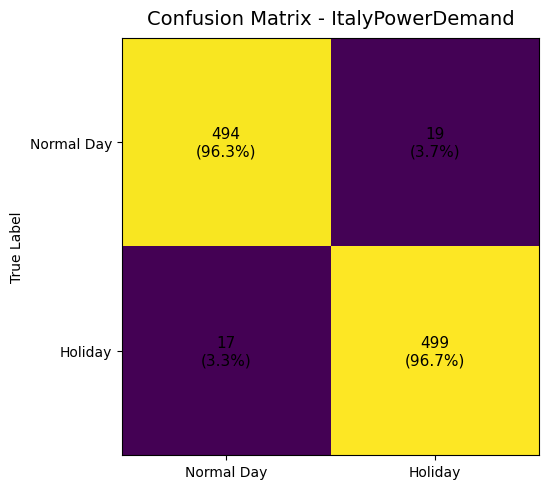

Accuracy on TEST: 0.9650145772594753

Classification Report:
               precision    recall  f1-score   support

           1       0.97      0.96      0.96       513
           2       0.96      0.97      0.97       516

    accuracy                           0.97      1029
   macro avg       0.97      0.97      0.97      1029
weighted avg       0.97      0.97      0.97      1029



In [ ]:
cm = confusion_matrix(y_test, y_pred)

classes = ["Normal Day", "Holiday"]

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm)

ax.set_title("Confusion Matrix - ItalyPowerDemand", fontsize=14, pad=10)
ax.set_ylabel("True Label")

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i,
            f"{cm[i, j]}\n({cm[i, j]/cm[i].sum()*100:.1f}%)",
            ha="center",
            va="center",
            fontsize=11
        )

plt.tight_layout()
plt.show()

print("Accuracy on TEST:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


# 6. Deployment

In [ ]:
import joblib

joblib.dump(mini_rocket, "minirocket.pkl")
joblib.dump(ridge_model, "ridge_model.pkl")


['ridge_model.pkl']